# About

The objective of this model is to predict the probability that a customer does not pay back their credit card balance amount. Our data set is comprised of their monthly customer profile. Per Kaggle, the purveyor of the website, "the target binary variable is calculated by observing 18 months performance window after the latest credit card statement . . . . if the customer does not pay [the amount due] 120 days after their latest statement date it is considered a default event."

The data set contains customer-level statement information. Features are anonymized, normalized, and fall into the following general categories:

D_* = Delinquency variables, S_* = Spend variables, P_* = Payment variables, B_* = Balance variables, R_* = Risk variables. 

The following features are categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Our task is to predict, for each customer_ID, the probability of a future payment default (target = 1).

Source(https://www.kaggle.com/competitions/amex-default-prediction/data?select=train_labels.csv)

# 1.0 Imports

A considerable amount of our work will ultimately rely on [PyCaret](https://pycaret.org/). Running the notebok requires importing it from outside of the Colab environment and, after running the following cell for the first time, restarting the notebook runtime. We can then continue with our imports.

In [ ]:
!pip install --pre pycaret --quiet

Beyond a special line of code to retrieve PyCaret, we import the standard data science packages in the following cell. Note that PyCaret will import its preferred version of a number of packages -- including numpy -- automatically, along with numerous other obscure packages.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 2.0 Data Acquisition

Initially, we used pip and a wide array of command-line statements to import a zip file containing four csv's into our environment. Ultimately, however, we opted to store the data -- unzipped -- in our google drive. The logic was simple. While it's impressive to see dozens of estoteric command line instructions doing impressive things, the fact remained that ingesting via download and expansion every time took about 20 minutes. By contrast, taking possession of the file and placing it in our directory brings data ingestion time down to about 5 seconds. Were this project undertaken in a collaborative setting, we would place the data in high-performance files and make them available on git hub. 

Running the code below will bring our data into the Colab environment. Caveat programmer: The original files contained 10 million observations. Though it would be a delight to have so much information at our disposal, our capacity allows for only 10% of the data to be used efficiently.

In [ ]:

train_labels = pd.read_csv('/content/drive/MyDrive/Amex/train_labels.csv', chunksize=1000000)
train_set = pd.read_csv('/content/drive/MyDrive/Amex/train_data.csv', chunksize=1000000)
sample_submission = pd.read_csv('/content/drive/MyDrive/Amex/sample_submission.csv', chunksize=1000000)
test_set = pd.read_csv('/content/drive/MyDrive/Amex/test_data.csv', nrows=1000000)

Our design matrix (i.e., training set) and target labels are provided in separate files. Here, we merge them together and add a an extra column for our convenience.

In [ ]:
df = pd.DataFrame()
for chunk, target in zip(train_set, train_labels):
  merger = chunk.merge(target, how='inner', on='customer_ID')
  merger['Count'] = 1
  df = df.append(merger, ignore_index=True)
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Count
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0,1
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0,1
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0,1
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0,1
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0,1


# 3.0 Exploratory Data Analysis

The next two cells provide us with a global view of our data set.

In [ ]:
print(f'We have {len(df.columns)} features in our data set (including the target and our count columns) and {df.shape[0]} observations.')

We have 192 features in our data set (including the target and our count columns) and 1000000 observations.


In [ ]:
print(df.dtypes[:25])

customer_ID     object
S_2             object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
R_1            float64
S_3            float64
D_41           float64
B_3            float64
D_42           float64
D_43           float64
D_44           float64
B_4            float64
D_45           float64
B_5            float64
R_2            float64
D_46           float64
D_47           float64
D_48           float64
D_49           float64
B_6            float64
B_7            float64
B_8            float64
D_50           float64
dtype: object


Our data look quite different when grouped.

In [ ]:
print(f'There are {len(df["customer_ID"].unique())} unique customers in our data set versus {len(df)} individual observations.\nThis suggests the data contain multiple transactions per customer.')

There are 82975 unique customers in our data set versus 1000000 individual observations.
This suggests the data contain multiple transactions per customer.


In [ ]:
df.groupby('customer_ID')['Count'].agg('sum').describe()

count    82975.000000
mean        12.051823
std          2.608744
min          1.000000
25%         13.000000
50%         13.000000
75%         13.000000
max         13.000000
Name: Count, dtype: float64

The above results are unexpected. The mean and median (marked '50%') are nearly the same. Furthermore, the same number characterizes the entire interquartile range.  This is either quite a coincidence or evidence that our data are manufactured.

As demonstrated by the graph below, a maximum of 13 observations were taken from a large number customers, while fewer than 13 transactions were collected from a minority of cases.

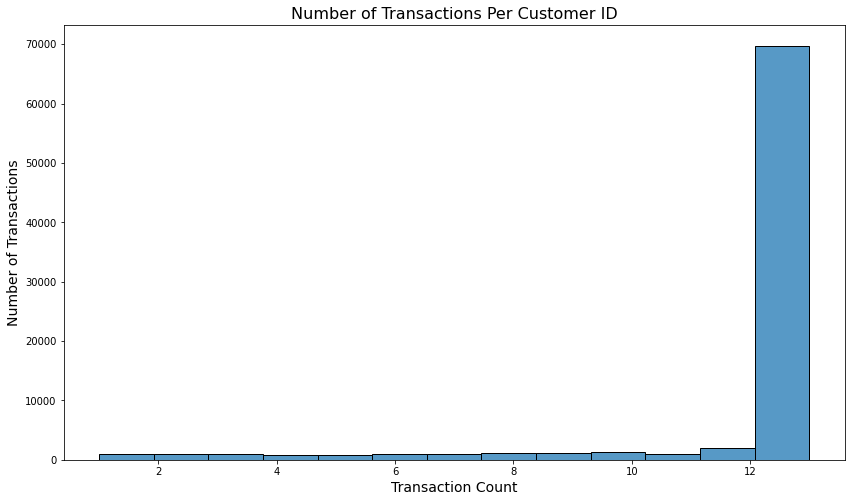

In [ ]:
group_obj = df.groupby(['customer_ID'])['Count'].sum().reset_index()
plt.figure(figsize = (14,8))
sns.histplot(data = group_obj, x = 'Count', bins=13)
plt.ylabel("Number of Transactions", size=14)
plt.xlabel("Transaction Count", size=14)
plt.title("Number of Transactions Per Customer ID", size=16);

Classification problems are typified by an imbalance between the positive and negative classes. There are fewer positive cases in our study than there are instances of the negative case. Represented by a '1' in our target column, our positive case is 'delinquency,' an admittedly negative event. Our negative case, represented by a '0' by in the target column, represents a customer whose account is in order. The following cell tells us the distribution between the positive and negative classes. 

In [ ]:
class_distribution = df.target.value_counts()
print(f'Approximately {round(class_distribution[1]/class_distribution[0],2)*100}% of observations are in the positive (delinquent) class.')
class_distribution

Approximately 33.0% of observations are in the positive (delinquent) class.


0    749613
1    250387
Name: target, dtype: int64

Features with cases missing data are commonplace in data analytics. In the cell below, we calculate that, on average, our features are missing just over 15% of their data.

In [ ]:
missing = round(((df.isna().sum())/len(df)),2) * 100
avg = round(((df.isna().sum())/len(df)),2)* 100
print(f'The mean percentage of missing values is {round(avg.mean(), 2)}%.')

The mean percentage of missing values is 15.11%.


To narrow the feature space to include only the most informative columns, we will keep only those columns with less at least 15% of their data.

In [ ]:
# the threshold is the percentage missing above which we no longer wish to consider the feature
threshold = .15
df = df.loc[:, df.isnull().mean() < threshold]
train_columns = list(df.columns)

Our feature space in our training set must match the feature space in our test set. To do this, we take the set intersection of the features in our training set, which now has fewer columns, and the columns in our test set.

In [ ]:
test_columns = list(test_set)
cols_to_keep = set(test_columns).intersection(set(train_columns))

The set intersection above provides us with the names of the features with which we will work. Below, we make the actual modifications to our data sets by keeping only the columns we've selected.

In [ ]:
test_modified = test_set[list(cols_to_keep)]
target = df['target']
train_modified = df[list(cols_to_keep)]

Here, we ensure that our target column is attached to our new training data frame.

In [ ]:
train_modified2 = pd.concat([train_modified, pd.DataFrame(target)], axis="columns")

In [ ]:
#train_modified2 = train_modified2.copy(deep=True)
#test_modified = test_modified.copy(deep=True)

To ensure we retain our original data (just in case) and seamlessly proceed to the feature engineering phase of our analysis, we make deep copies of both data frames and introduce a change of variable.

In [ ]:
train = train_modified2.copy(deep=True)
test = test_modified.copy(deep=True)

#4.0 Feature Engineering

Our dataframes contain date data. This can be mined for the month, the number of the day during the month, and the day of the week. Below, we extract this information for future use, in both our training and testing sets. 

In [ ]:
train['S_2'] = train['S_2'].astype('datetime64[ns]')
train['month'] = train['S_2'].dt.month
train['day'] = train['S_2'].dt.day
train['weekday'] = train['S_2'].dt.day_name()
train.drop(['S_2'], axis=1, inplace=True)

In [ ]:
test['S_2'] = test['S_2'].astype('datetime64[ns]')
test['month'] = test['S_2'].dt.month
test['day'] = test['S_2'].dt.day
test['weekday'] = test['S_2'].dt.day_name()
test.drop(['S_2'], axis=1, inplace=True)

For the curious, the new date information vectors are now appended to our data sets, as shown in the following two cells.

In [ ]:
train.loc[:,'D_145':].head()

NameError: ignored

In [ ]:
test.loc[:,'D_145':].head()

We know which columns contain continuous data and which features are categorical. Here's we separate the two and fill the missing data in continuous columns with the columns' mean. The mean of any relevant training set column is also placed in the empty slots found in the corresponding vector in the training set. This allows us to avoid data leakage.

The cell immmediately below illustrates our work on features containing continuous values.

In [ ]:
# fill select columns with mean
revised_columns = cols_to_keep - set(['D_63', 'D_64', 'D_68', 'B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'S_2', 'customer_ID'])
revised_columns = list(revised_columns)
train[revised_columns] = train[revised_columns].fillna(value=train[revised_columns].mean())
# missing test values replaced with train column means to prevent data leakage
test[revised_columns] = test[revised_columns].fillna(value=train[revised_columns].mean())

In the next cell, we demonstrate how we cope with missing categorical data. Specifically, we find the most frequently seen data point in the training set for each categorical vector and use it to fill-in missing data. We take those same values and repeat the process on the training set.

In [ ]:
train['D_63'].fillna('CO', inplace=True)
train['D_64'].fillna('O', inplace=True)
train['D_68'].fillna(6, inplace=True)
train['B_30'].fillna(0, inplace=True)
train['B_31'].fillna(1, inplace=True)
train['B_38'].fillna(2, inplace=True)
train['D_114'].fillna(1, inplace=True)
train['D_116'].fillna(0, inplace=True)
train['D_117'].fillna(-1, inplace=True)
train['D_120'].fillna(0, inplace=True)
train['D_126'].fillna(1, inplace=True)
print("Training Set Missing Values Imputed.")
print('\n')
test['D_63'].fillna('CO', inplace=True)
test['D_64'].fillna('O', inplace=True)
test['D_68'].fillna(6, inplace=True)
test['B_30'].fillna(0, inplace=True)
test['B_31'].fillna(1, inplace=True)
test['B_38'].fillna(2, inplace=True)
test['D_114'].fillna(1, inplace=True)
test['D_116'].fillna(0, inplace=True)
test['D_117'].fillna(-1, inplace=True)
test['D_120'].fillna(0, inplace=True)
test['D_126'].fillna(1, inplace=True)
print("Missing values in test set replaced with mean of training set to prevent data leakage.")

Training Set Missing Values Imputed.


Missing values in test set replaced with mean of training set to prevent data leakage.


Numerical data representing categories and string data representing categorical information must be transformed to be useful in this context. Below, we import the binary encoder used to perform the transformation. Note, while we typically make a practice of doing all imports at the start of our notebook, issues with loading and working with PyCaret for the first time made this the most expedient choice.

In [ ]:
%pip install --upgrade category_encoders --quiet
import category_encoders
from category_encoders import BinaryEncoder

Here, we specify the columns whose encoding we will change, instantiate separate encoders for the training and test sets, and transform our data. 

In [ ]:
cols = ['D_63', 'D_64', 'D_68', 'B_30', 'B_31', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'month', 'day', 'weekday']
encoder = BinaryEncoder(cols = cols, return_df = True)
train = encoder.fit_transform(train)
train = train.copy(deep=True)

encoder2 = BinaryEncoder(cols = cols, return_df = True)
test = encoder2.fit_transform(test)
test = test.copy(deep = True)

# 5.0 Modeling and Model Testing

PyCaret is designed to do everything we just accomplished automatically. This begs the question: Did we just waste our time? The answer is a firm, "no." Using black boxes is horrible practice. Consequently, we've limited our use of PyCaret, restricting it to the modeling phase of our study.

Though we have a test set, PyCaret splits the data in its own way for training and testing. This is what is occurring in the following cell.

In [ ]:
y = train['target']
X_pycaret = train.copy(deep=True)
#X_pycaret = X_pycaret.drop(['Count', 'customer_ID'], axis=1)
data = X_pycaret.sample(frac=0.70, random_state=144).reset_index(drop=True)
data_unseen = X_pycaret.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (700000, 182)
Unseen Data For Predictions: (300000, 182)


This is one of our more exciting lines of code. Here, we setup PyCaret to use our training data and target to try several models that we believe could assist us in addressing our research question. PyCaret will also correct for multicollinearity (+70% correlation) and perform k-fold crossvalidation on our models where k = 3. Typically, we cross-validate on the interval [5, 10], however, we are resource constrained. SMOTE has also been selected to correct our class imbalance.

In [ ]:
from pycaret.classification import *
s = setup(data = data, target = 'target', remove_multicollinearity=True, multicollinearity_threshold = .70, iterative_imputation_iters=2, fold=3, use_gpu=True, fix_imbalance=True, session_id=1024)

,Description,Value
0,Session id,1024
1,Target,target
2,Target type,Binary
3,Original data shape,"(700000, 182)"
4,Transformed data shape,"(944341, 147)"
5,Transformed train set shape,"(734340, 147)"
6,Transformed test set shape,"(210001, 147)"
7,Numeric features,180
8,Categorical features,1
9,Preprocess,True


After a 5 hour run, we received intelligence on the performance of 14 different models. That's fantastic, however, we prefer that an economy of time be used when modeling. We have, thus, limited the number of models readers will see to only the most salient.

In [ ]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9876,0.9994,0.9757,0.9749,0.9753,0.9670,0.9670,16.6367
lr,Logistic Regression,0.9872,0.9993,0.9752,0.9739,0.9745,0.9660,0.9660,226.8400
rf,Random Forest Classifier,0.9872,0.9989,0.9760,0.9731,0.9746,0.9661,0.9661,95.2367
gbc,Gradient Boosting Classifier,0.9867,0.9993,0.9769,0.9704,0.9736,0.9648,0.9648,2229.7067
ada,Ada Boost Classifier,0.9859,0.9993,0.9729,0.9710,0.9720,0.9626,0.9626,482.2967
et,Extra Trees Classifier,0.9851,0.9994,0.9481,0.9921,0.9696,0.9597,0.9602,31.1700
svm,SVM - Linear Kernel,0.9848,0.0000,0.9717,0.9677,0.9697,0.9595,0.9595,12.1567
dt,Decision Tree Classifier,0.9819,0.9764,0.9655,0.9625,0.9640,0.9519,0.9519,23.5867
ridge,Ridge Classifier,0.9768,0.0000,0.9075,1.0000,0.9515,0.9363,0.9382,8.3867
lda,Linear Discriminant Analysis,0.9768,0.9988,0.9075,1.0000,0.9515,0.9363,0.9382,20.3700


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
predictions = predict_model(best, data=test)

NameError: ignored